In [2]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

In [3]:
benchmark_path = "../benchmarks/qubo_known/2"

In [3]:
from longestpath import gen_num_edges
from benchmarking import new_benchmark
from longestpath.solvers import Solver
import numpy as np
import inspect

def generate():
    n = 30
    return [
        gen_num_edges(n, round(n * d))
            for d in np.arange(1.2, 3.7, 0.2) for _ in range(5)
    ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "BRANCH_N_BOUND"),
	Solver("qubo", use_known_length=True, num_reads=100, num_sweeps=1000, beta_range=(0.1, 2.0)),
	Solver("ilp"),
	Solver("anneal", use_known_length=True, num_reads=2000, num_sweeps=32, alpha= 0.9, initial_temp= 1.0, final_temp = 0.00122),
	Solver("anneal", use_known_length=True, num_reads=2000, num_sweeps=128, alpha= 0.9, initial_temp= 1.0, final_temp = 0.00122),
], params_code = params_code, override_benchmark_path=benchmark_path)

In [11]:
from benchmarking import Benchmark
import longestpath.brute as brute

benchmark = Benchmark.load(benchmark_path)

for graph_id, graph in benchmark.graphs:
    result = brute.solve(graph, "BRANCH_N_BOUND")
    length = len(result['path'])-1
    graph.set_known_longest_path_length(length)

benchmark.run(retryFailures=True, timeout=60, solver_indices=[4])

graph: 0.txt, solver: anneal(use_known_length=True, num_reads=10000, num_sweeps=128, alpha=0.9, initial_temp=1.0, final_temp=0.00122) ... ✅
length: 9, run_time: 0.29292700000223704
graph: 1.txt, solver: anneal(use_known_length=True, num_reads=10000, num_sweeps=128, alpha=0.9, initial_temp=1.0, final_temp=0.00122) ... ✅
length: 6, run_time: 0.23792204100027448
graph: 2.txt, solver: anneal(use_known_length=True, num_reads=10000, num_sweeps=128, alpha=0.9, initial_temp=1.0, final_temp=0.00122) ... ✅
length: 9, run_time: 0.19004504199983785
graph: 3.txt, solver: anneal(use_known_length=True, num_reads=10000, num_sweeps=128, alpha=0.9, initial_temp=1.0, final_temp=0.00122) ... ✅
length: 11, run_time: 0.11302708299626829
graph: 4.txt, solver: anneal(use_known_length=True, num_reads=10000, num_sweeps=128, alpha=0.9, initial_temp=1.0, final_temp=0.00122) ... ✅
length: 12, run_time: 0.0610352090006927
graph: 5.txt, solver: anneal(use_known_length=True, num_reads=10000, num_sweeps=128, alpha=0.9

SystemExit: 130

/opt/homebrew/Caskroom/miniconda/base/envs/tno-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


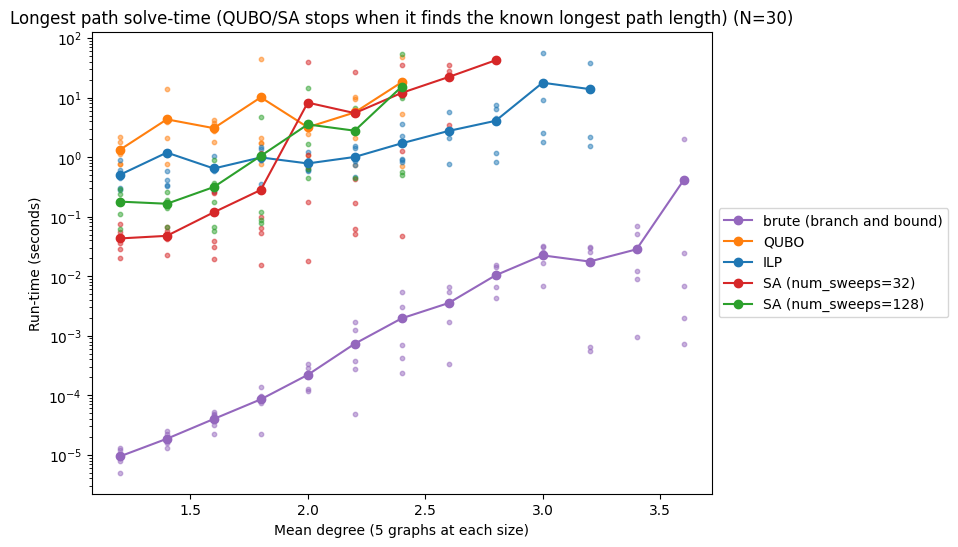

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from benchmarking import Benchmark
import longestpath.brute as brute


benchmark = Benchmark.load(benchmark_path)

actual_lengths = {}
for graph_id, graph in benchmark.graphs:
    result = brute.solve(graph, "BRANCH_N_BOUND")
    length = len(result['path'])-1
    actual_lengths[graph_id] = length

df = benchmark.get_dataframe()
df = df[df['failure'].isnull()]
df['actual_length'] = df.apply(lambda row: actual_lengths[row['graph_id']], axis=1)
shorter_paths = df[df['length'] != df['actual_length']]
df = df[df['length'] == df['actual_length']]

solver_plot_names = {
    0: 'brute (branch and bound)',
    1: "QUBO",
    2: 'ILP',
    3: "SA (num_sweeps=32)",
    4: "SA (num_sweeps=128)",
}

colordict = dict(zip(sorted(solver_plot_names.values()), mcolors.TABLEAU_COLORS))

# df['solver_plot_name'] = df.apply(axis=1, func=lambda row: solver_plot_names.get(row['solver'], row['solver_name']))

to_plot = df.groupby(['average_out_degree', 'solver']).agg({'run_time': 'mean'}).reset_index() \
    .pivot(index='average_out_degree', columns='solver', values='run_time') \
    .rename(columns=solver_plot_names);

to_plot.plot(style="o-", color=colordict)

for i in range(len(benchmark.solvers)):
    solver_df = df[df["solver"] == i]
    plt.scatter(solver_df['average_out_degree'], solver_df['run_time'], label=None, color=colordict[solver_plot_names[i]], alpha=0.5, s=10)

plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("Run-time (seconds)")
plt.xlabel("Mean degree (5 graphs at each size)")
plt.title(f"Longest path solve-time (QUBO/SA stops when it finds the known longest path length) (N=30)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(8, 6)

plt.savefig(os.path.join(benchmark.benchmark_path, "qubo_known_n30.png"), dpi=400, bbox_inches='tight')